
<a id='arma'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Covariance Stationary Processes

## Colab Instructions

Colab does not have direct Julia support, and it must be installed each time you are working on a notebook.  

Instructions:

1. Ignore any errors about a missing kernel when loading the notebook.  Choose `Run Anyway` when it prompts that the notebook wasn't authored by google.

2. Run the cell below this with `Shift+Enter`.
    -  It will **5 to 8 minutes** the first time you run it for Julia and key packages to install

3. Refresh your browser, and then execute any code as normal.
  - Even after installation, there will be more precompiling latency for some packages. 

In [ ]:
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.2-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
    julia -e 'using Pkg; pkg"add IJulia InstantiateFromURL; precompile;"'
    julia -e 'using InstantiateFromURL; github_project("QuantEcon/quantecon-notebooks-julia", version = "0.8.0", instantiate = true, precompile = false); using Plots, Distributions, Parameters, NLsolve, ForwardDiff, Expectations'
    echo 'Done'
fi


## Contents

- [Covariance Stationary Processes](#Covariance-Stationary-Processes)  
  - [Overview](#Overview)  
  - [Introduction](#Introduction)  
  - [Spectral Analysis](#Spectral-Analysis)  
  - [Implementation](#Implementation)  

## Overview

In this lecture we study covariance stationary linear stochastic processes, a
class of models routinely used to study economic and financial time series.

This class has the advantage of being

1. simple enough to be described by an elegant and comprehensive theory  
1. relatively broad in terms of the kinds of dynamics it can represent  


We consider these models in both the time and frequency domain.

### ARMA Processes

We will focus much of our attention on linear covariance stationary models with a finite number of parameters.

In particular, we will study stationary ARMA processes, which form a cornerstone of the standard theory of time series analysis.

Every ARMA processes can be represented in [linear state space](../tools_and_techniques/linear_models.html) form.

However, ARMA have some important structure that makes it valuable to study them separately.

### Spectral Analysis

Analysis in the frequency domain is also called spectral analysis.

In essence, spectral analysis provides an alternative representation of the
autocovariance function of a covariance stationary process.

Having a second representation of this important object

- shines light on the dynamics of the process in question  
- allows for a simpler, more tractable representation in some important cases  


The famous *Fourier transform* and its inverse are used to map between the two representations.

### Other Reading

For supplementary reading, see.

- [[LS18]](../zreferences.html#ljungqvist2012), chapter 2  
- [[Sar87]](../zreferences.html#sargent1987), chapter 11  
- John Cochrane’s <a href=/_static/pdfs/time_series_book.pdf download>notes on time series analysis</a>, chapter 8  
- [[Shi95]](../zreferences.html#shiryaev1995), chapter 6  
- [[CC08]](../zreferences.html#cryerchan2008), all  

### Setup

In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.8.0")

In [2]:
using LinearAlgebra, Statistics

## Introduction

Consider a sequence of random variables $ \{ X_t \} $ indexed by $ t \in \mathbb Z $ and taking values in $ \mathbb R $.

Thus, $ \{ X_t \} $ begins in the infinite past and extends to the infinite future — a convenient and standard assumption.

As in other fields, successful economic modeling typically assumes the existence of features that are constant over time.

If these assumptions are correct, then each new observation $ X_t, X_{t+1},\ldots $ can provide additional information about the time-invariant features, allowing us to  learn from as data arrive.

For this reason, we will focus in what follows on processes that are *stationary* — or become so after a transformation
(see for example [this lecture](additive_functionals.html) and [this lecture](multiplicative_functionals.html)).


<a id='arma-defs'></a>

### Definitions


<a id='index-3'></a>
A real-valued stochastic process $ \{ X_t \} $ is called *covariance stationary* if

1. Its mean $ \mu := \mathbb E X_t $ does not depend on $ t $.  
1. For all $ k $ in $ \mathbb Z $, the $ k $-th autocovariance $ \gamma(k) := \mathbb E (X_t - \mu)(X_{t + k} - \mu) $ is finite and depends only on $ k $.  


The function $ \gamma \colon \mathbb Z \to \mathbb R $ is called the *autocovariance function* of the process.

Throughout this lecture, we will work exclusively with zero-mean (i.e., $ \mu = 0 $) covariance stationary processes.

The zero-mean assumption costs nothing in terms of generality, since working with non-zero-mean processes involves no more than adding a constant.

### Example 1: White Noise

Perhaps the simplest class of covariance stationary processes is the white noise processes.

A process $ \{ \epsilon_t \} $ is called a *white noise process* if

1. $ \mathbb E \epsilon_t = 0 $  
1. $ \gamma(k) = \sigma^2 \mathbf 1\{k = 0\} $ for some $ \sigma > 0 $  


(Here $ \mathbf 1\{k = 0\} $ is defined to be 1 if $ k = 0 $ and zero otherwise)

White noise processes play the role of **building blocks** for processes with more complicated dynamics.


<a id='generalized-lps'></a>

### Example 2: General Linear Processes

From the simple building block provided by white noise, we can construct a very flexible family of covariance stationary processes — the *general linear processes*


<a id='equation-ma-inf'></a>
$$
X_t = \sum_{j=0}^{\infty} \psi_j \epsilon_{t-j},
\qquad t \in \mathbb Z \tag{1}
$$

where

- $ \{\epsilon_t\} $ is white noise  
- $ \{\psi_t\} $ is a square summable sequence in $ \mathbb R $ (that is, $ \sum_{t=0}^{\infty} \psi_t^2 < \infty $)  


The sequence $ \{\psi_t\} $ is often called a *linear filter*.

Equation [(1)](#equation-ma-inf) is said to present  a **moving average** process or a moving average representation.

With some manipulations it is possible to confirm that the autocovariance function for [(1)](#equation-ma-inf) is


<a id='equation-ma-inf-ac'></a>
$$
\gamma(k) = \sigma^2 \sum_{j=0}^{\infty} \psi_j \psi_{j+k} \tag{2}
$$

By the [Cauchy-Schwartz inequality](https://en.wikipedia.org/wiki/Cauchy%E2%80%93Schwarz_inequality) one can show that $ \gamma(k) $ satisfies equation [(2)](#equation-ma-inf-ac).

Evidently, $ \gamma(k) $ does not depend on $ t $.

### Wold’s Decomposition

Remarkably, the class of general linear processes goes a long way towards
describing the entire class of zero-mean covariance stationary processes.

In particular, [Wold’s decomposition theorem](https://en.wikipedia.org/wiki/Wold%27s_theorem) states that every
zero-mean covariance stationary process $ \{X_t\} $ can be written as

$$
X_t = \sum_{j=0}^{\infty} \psi_j \epsilon_{t-j} + \eta_t
$$

where

- $ \{\epsilon_t\} $ is white noise  
- $ \{\psi_t\} $ is square summable  
- $ \eta_t $ can be expressed as a linear function of $ X_{t-1}, X_{t-2},\ldots $ and is perfectly predictable over arbitrarily long horizons  


For intuition and further discussion, see [[Sar87]](../zreferences.html#sargent1987), p. 286.

### AR and MA


<a id='index-8'></a>
General linear processes are a very broad class of processes.

It often pays to specialize to those for which there exists a representation having only finitely many parameters.

(Experience and theory combine to indicate that models with a relatively small number of parameters typically perform better than larger models, especially for forecasting)

One very simple example of such a model is the first-order autoregressive or AR(1) process


<a id='equation-ar1-rep'></a>
$$
X_t = \phi X_{t-1} + \epsilon_t
\quad \text{where} \quad
| \phi | < 1
\quad \text{and } \{ \epsilon_t \} \text{ is white noise} \tag{3}
$$

By direct substitution, it is easy to verify that $ X_t = \sum_{j=0}^{\infty} \phi^j \epsilon_{t-j} $.

Hence $ \{X_t\} $ is a general linear process.

Applying [(2)](#equation-ma-inf-ac) to the previous expression for $ X_t $, we get the AR(1) autocovariance function


<a id='equation-ar-acov'></a>
$$
\gamma(k) = \phi^k \frac{\sigma^2}{1 - \phi^2},
\qquad k = 0, 1, \ldots \tag{4}
$$

The next figure plots an example of this function for $ \phi = 0.8 $ and $ \phi = -0.8 $ with $ \sigma = 1 $

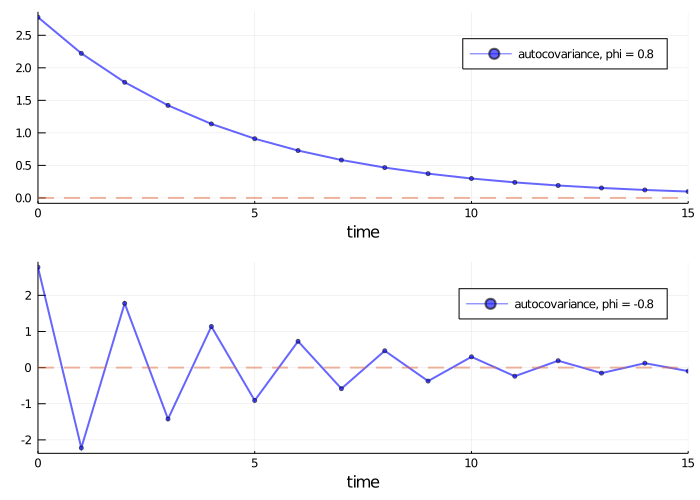

In [3]:
using Plots
gr(fmt=:png);

plt_1=plot()
plt_2=plot()
plots = [plt_1, plt_2]

for (i, ϕ) in enumerate((0.8, -0.8))
    times = 0:16
    acov = [ϕ.^k ./ (1 - ϕ.^2) for k in times]
    label = "autocovariance, phi = $ϕ"
    plot!(plots[i], times, acov, color=:blue, lw=2, marker=:circle, markersize=3,
          alpha=0.6, label=label)
    plot!(plots[i], legend=:topright, xlabel="time", xlim=(0,15))
    plot!(plots[i], seriestype=:hline, [0], linestyle=:dash, alpha=0.5, lw=2, label="")
end
plot(plots[1], plots[2], layout=(2,1), size=(700,500))

Another very simple process is the MA(1) process (here MA means “moving average”)

$$
X_t = \epsilon_t + \theta \epsilon_{t-1}
$$

You will be able to verify that

$$
\gamma(0) = \sigma^2 (1 + \theta^2),
\quad
\gamma(1) = \sigma^2 \theta,
\quad \text{and} \quad
\gamma(k) = 0 \quad \forall \, k > 1
$$

The AR(1) can be generalized to an AR($ p $) and likewise for the MA(1).

Putting all of this together, we get the

### ARMA Processes

A stochastic process $ \{X_t\} $ is called an *autoregressive moving
average process*, or ARMA($ p,q $), if it can be written as


<a id='equation-arma'></a>
$$
X_t = \phi_1 X_{t-1} + \cdots + \phi_p X_{t-p} +
    \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q} \tag{5}
$$

where $ \{ \epsilon_t \} $ is white noise.

An alternative notation for ARMA processes uses the *lag operator* $ L $.

**Def.** Given arbitrary variable $ Y_t $, let $ L^k Y_t := Y_{t-k} $.

It turns out that

- lag operators facilitate  succinct representations for linear stochastic processes  
- algebraic manipulations that treat the lag operator as an ordinary scalar  are legitimate  


Using $ L $, we can rewrite [(5)](#equation-arma) as


<a id='equation-arma-lag'></a>
$$
L^0 X_t - \phi_1 L^1 X_t - \cdots - \phi_p L^p X_t = L^0 \epsilon_t + \theta_1 L^1 \epsilon_t + \cdots + \theta_q L^q \epsilon_t \tag{6}
$$

If we let $ \phi(z) $ and $ \theta(z) $ be the polynomials


<a id='equation-arma-poly'></a>
$$
\phi(z) := 1 - \phi_1 z - \cdots - \phi_p z^p
\quad \text{and} \quad
\theta(z) := 1 + \theta_1 z + \cdots + \theta_q z^q \tag{7}
$$

then [(6)](#equation-arma-lag)  becomes


<a id='equation-arma-lag1'></a>
$$
\phi(L) X_t = \theta(L) \epsilon_t \tag{8}
$$

In what follows we **always assume** that the roots of the polynomial $ \phi(z) $ lie outside the unit circle in the complex plane.

This condition is sufficient to guarantee that the ARMA($ p,q $) process is convariance stationary.

In fact it implies that the process falls within the class of general linear processes [described above](#generalized-lps).

That is, given an ARMA($ p,q $) process $ \{ X_t \} $ satisfying the unit circle condition, there exists a square summable sequence $ \{\psi_t\} $ with $ X_t = \sum_{j=0}^{\infty} \psi_j \epsilon_{t-j} $ for all $ t $.

The sequence $ \{\psi_t\} $ can be obtained by a recursive procedure outlined on page 79 of [[CC08]](../zreferences.html#cryerchan2008).

The function $ t \mapsto \psi_t $ is often called the *impulse response function*.

## Spectral Analysis

Autocovariance functions provide a great deal of information about covariance stationary processes.

In fact, for zero-mean Gaussian processes, the autocovariance function characterizes the entire joint distribution.

Even for non-Gaussian processes, it provides a significant amount of information.

It turns out that there is an alternative representation of the autocovariance function of a covariance stationary process, called the *spectral density*.

At times, the spectral density is easier to derive, easier to manipulate, and provides additional intuition.

### Complex Numbers

Before discussing the spectral density, we invite you to recall the main properties of complex numbers (or [skip to the next section](#arma-specd)).

It can be helpful to remember that, in a formal sense, complex numbers are just points $ (x, y) \in \mathbb R^2 $ endowed with a specific notion of multiplication.

When $ (x, y) $ is regarded as a complex number, $ x $ is called the *real part* and $ y $ is called the *imaginary part*.

The *modulus* or *absolute value* of a complex number $ z = (x, y) $ is just its Euclidean norm in $ \mathbb R^2 $, but is usually written as $ |z| $ instead of $ \|z\| $.

The product of two complex numbers $ (x, y) $ and $ (u, v) $ is defined to be $ (xu - vy, xv + yu) $, while addition is standard pointwise vector addition.

When endowed with these notions of multiplication and addition, the set of complex numbers forms a [field](https://en.wikipedia.org/wiki/Field_%28mathematics%29) — addition and multiplication play well together, just as they do in $ \mathbb R $.

The complex number $ (x, y) $ is often written as $ x + i y $, where $ i $ is called the *imaginary unit*, and is understood to obey $ i^2 = -1 $.

The $ x + i y $ notation provides an easy way to remember the definition of multiplication given above, because, proceeding naively,

$$
(x + i y) (u + i v) = xu - yv + i (xv + yu)
$$

Converted back to our first notation, this becomes $ (xu - vy, xv + yu) $ as promised.

Complex numbers can be represented in  the polar form $ r e^{i \omega} $ where

$$
r e^{i \omega} := r (\cos(\omega) + i \sin(\omega)) = x + i y
$$

where $ x = r \cos(\omega), y = r \sin(\omega) $, and $ \omega = \arctan(y/z) $ or $ \tan(\omega) = y/x $.


<a id='arma-specd'></a>

### Spectral Densities

Let $ \{ X_t \} $ be a covariance stationary process with autocovariance function $ \gamma $  satisfying $ \sum_{k} \gamma(k)^2 < \infty $.

The *spectral density* $ f $ of $ \{ X_t \} $ is defined as the [discrete time Fourier transform](https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform) of its autocovariance function $ \gamma $

$$
f(\omega) := \sum_{k \in \mathbb Z} \gamma(k) e^{-i \omega k},
\qquad \omega \in \mathbb R
$$

(Some authors normalize the expression on the right by constants such as $ 1/\pi $ — the convention chosen  makes little difference provided you are consistent)

Using the fact that $ \gamma $ is *even*, in the sense that $ \gamma(t) = \gamma(-t) $ for all $ t $, we can show that


<a id='equation-arma-sd-cos'></a>
$$
f(\omega) = \gamma(0) + 2 \sum_{k \geq 1} \gamma(k) \cos(\omega k) \tag{9}
$$

It is not difficult to confirm that $ f $ is

- real-valued  
- even ($ f(\omega) = f(-\omega) $   ),  and  
- $ 2\pi $-periodic, in the sense that $ f(2\pi + \omega) = f(\omega) $ for all $ \omega $  


It follows that the values of $ f $ on $ [0, \pi] $ determine the values of $ f $ on
all of $ \mathbb R $ — the proof is an exercise.

For this reason it is standard to plot the spectral density only on the interval $ [0, \pi] $.


<a id='arma-wnsd'></a>

### Example 1: White Noise

Consider a white noise process $ \{\epsilon_t\} $ with standard deviation $ \sigma $.

It is easy to check that in  this case $ f(\omega) = \sigma^2 $.  So $ f $ is a constant function.

As we will see, this can be interpreted as meaning that “all frequencies are equally present”.

(White light has this property when frequency refers to the visible spectrum, a connection that provides the origins of the term “white noise”)

### Example 2: AR and MA and ARMA


<a id='ar1-acov'></a>
It is an exercise to show that the MA(1) process $ X_t = \theta \epsilon_{t-1} + \epsilon_t $ has spectral density


<a id='equation-ma1-sd-ed'></a>
$$
f(\omega)
= \sigma^2 ( 1 + 2 \theta \cos(\omega) + \theta^2 ) \tag{10}
$$

With a bit more effort, it is possible to show (see, e.g., p. 261 of [[Sar87]](../zreferences.html#sargent1987)) that the spectral density of the AR(1) process $ X_t = \phi X_{t-1} + \epsilon_t $ is


<a id='equation-ar1-sd-ed'></a>
$$
f(\omega)
= \frac{\sigma^2}{ 1 - 2 \phi \cos(\omega) + \phi^2 } \tag{11}
$$

More generally, it can be shown that the spectral density of the ARMA process [(5)](#equation-arma) is


<a id='arma-spec-den'></a>

<a id='equation-arma-sd'></a>
$$
f(\omega) = \left| \frac{\theta(e^{i\omega})}{\phi(e^{i\omega})} \right|^2 \sigma^2 \tag{12}
$$

where

- $ \sigma $ is the standard deviation of the white noise process $ \{\epsilon_t\} $  
- the polynomials $ \phi(\cdot) $ and $ \theta(\cdot) $ are as defined in [(7)](#equation-arma-poly)  


The derivation of [(12)](#equation-arma-sd) uses the fact that convolutions become products under Fourier transformations.

The proof is elegant and can be found in many places — see, for example, [[Sar87]](../zreferences.html#sargent1987), chapter 11, section 4.

It is a nice exercise to verify that [(10)](#equation-ma1-sd-ed) and [(11)](#equation-ar1-sd-ed) are indeed special cases of [(12)](#equation-arma-sd).

### Interpreting the Spectral Density


<a id='index-18'></a>
Plotting [(11)](#equation-ar1-sd-ed) reveals the shape of the spectral density for the AR(1) model when $ \phi $ takes the values 0.8 and -0.8 respectively

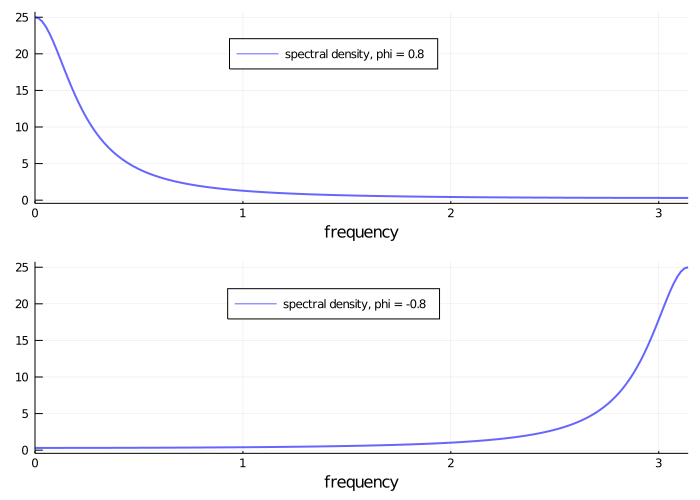

In [4]:
ar1_sd(ϕ, ω) = 1 ./ (1 .- 2 * ϕ * cos.(ω) .+ ϕ.^2)

ω_s = range(0, π, length = 180)

plt_1=plot()
plt_2=plot()
plots=[plt_1, plt_2]

for (i, ϕ) in enumerate((0.8, -0.8))
    sd = ar1_sd(ϕ, ω_s)
    label = "spectral density, phi = $ϕ"
    plot!(plots[i], ω_s, sd, color=:blue, alpha=0.6, lw=2, label=label)
    plot!(plots[i], legend=:top, xlabel="frequency", xlim=(0,π))
end
plot(plots[1], plots[2], layout=(2,1), size=(700,500))

These spectral densities correspond to the autocovariance functions for the
AR(1) process [shown above](#ar1-acov).

Informally, we think of the spectral density as being large at those $ \omega \in [0, \pi] $ at which
the autocovariance function seems approximately to exhibit big damped cycles.

To see the idea, let’s consider why, in the lower panel of the preceding figure, the spectral density for the case $ \phi = -0.8 $ is large at $ \omega = \pi $.

Recall that the spectral density can be expressed as


<a id='equation-sumpr'></a>
$$
f(\omega)
= \gamma(0) + 2 \sum_{k \geq 1} \gamma(k) \cos(\omega k)
= \gamma(0) + 2 \sum_{k \geq 1} (-0.8)^k \cos(\omega k) \tag{13}
$$

When we evaluate this at $ \omega = \pi $, we get a large number because
$ \cos(\pi k) $ is large and positive when $ (-0.8)^k $ is
positive, and large in absolute value and negative when $ (-0.8)^k $ is negative.

Hence the product is always large and positive, and hence the sum of the
products on the right-hand side of [(13)](#equation-sumpr) is large.

These ideas are illustrated in the next figure, which has $ k $ on the horizontal axis

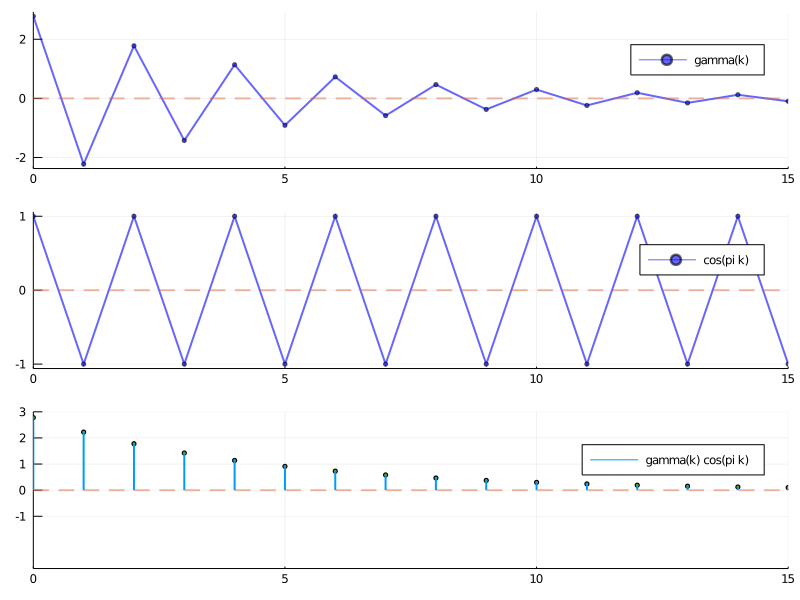

In [5]:
ϕ = -0.8
times = 0:16
y1 = [ϕ.^k ./ (1 - ϕ.^2) for k in times]
y2 = [cos.(π * k) for k in times]
y3 = [a * b for (a, b) in zip(y1, y2)]

# Autocovariance when ϕ = -0.8
plt_1 = plot(times, y1, color=:blue, lw=2, marker=:circle, markersize=3,
             alpha=0.6, label="gamma(k)")
plot!(plt_1, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_1, legend=:topright, xlim=(0,15), yticks=[-2, 0, 2])

# Cycles at frequence π
plt_2 = plot(times, y2, color=:blue, lw=2, marker=:circle, markersize=3,
             alpha=0.6, label="cos(pi k)")
plot!(plt_2, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_2, legend=:topright, xlim=(0,15), yticks=[-1, 0, 1])

# Product
plt_3 = plot(times, y3, seriestype=:sticks, marker=:circle, markersize=3,
             lw=2, label="gamma(k) cos(pi k)")
plot!(plt_3, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_3, legend=:topright, xlim=(0,15), ylim=(-3,3), yticks=[-1, 0, 1, 2, 3])

plot(plt_1, plt_2, plt_3, layout=(3,1), size=(800,600))

On the other hand, if we evaluate $ f(\omega) $ at $ \omega = \pi / 3 $, then the cycles are
not matched, the sequence $ \gamma(k) \cos(\omega k) $ contains
both positive and negative terms, and hence the sum of these terms is much smaller

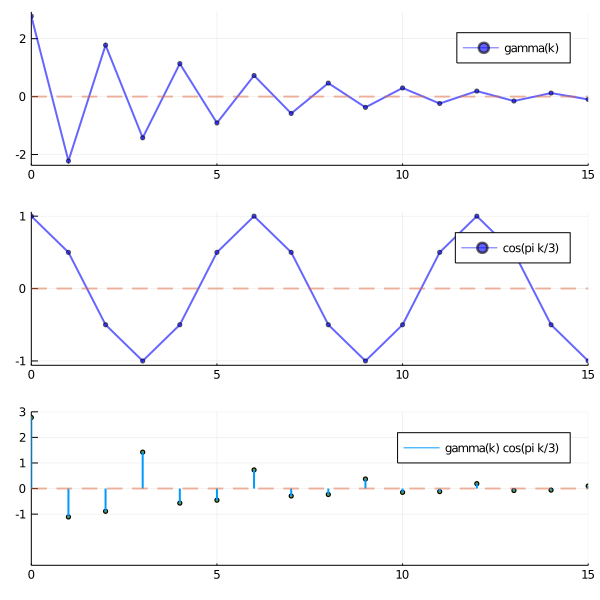

In [6]:
ϕ = -0.8
times = 0:16
y1 = [ϕ.^k ./ (1 - ϕ.^2) for k in times]
y2 = [cos.(π * k/3) for k in times]
y3 = [a * b for (a, b) in zip(y1, y2)]

# Autocovariance when ϕ = -0.8
plt_1 = plot(times, y1, color=:blue, lw=2, marker=:circle, markersize=3,
             alpha=0.6, label="gamma(k)")
plot!(plt_1, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_1, legend=:topright, xlim=(0,15), yticks=[-2, 0, 2])

# Cycles at frequence π
plt_2 = plot(times, y2, color=:blue, lw=2, marker=:circle, markersize=3,
             alpha=0.6, label="cos(pi k/3)")
plot!(plt_2, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_2, legend=:topright, xlim=(0,15), yticks=[-1, 0, 1])

# Product
plt_3 = plot(times, y3, seriestype=:sticks, marker=:circle, markersize=3,
             lw=2, label="gamma(k) cos(pi k/3)")
plot!(plt_3, seriestype=:hline, [0], linestyle=:dash, alpha=0.5,
      lw=2, label="")
plot!(plt_3, legend=:topright, xlim=(0,15), ylim=(-3,3), yticks=[-1, 0, 1, 2, 3])

plot(plt_1, plt_2, plt_3, layout=(3,1), size=(600,600))

In summary, the spectral density is large at frequencies $ \omega $ where the autocovariance function exhibits damped cycles.

### Inverting the Transformation


<a id='index-19'></a>
We have just seen that the spectral density is useful in the sense that it provides a frequency-based perspective on the autocovariance structure of a covariance stationary process.

Another reason that the spectral density is useful is that it can be “inverted” to recover the autocovariance function via the *inverse Fourier transform*.

In particular, for all $ k \in \mathbb Z $, we have


<a id='equation-ift'></a>
$$
\gamma(k) = \frac{1}{2 \pi} \int_{-\pi}^{\pi} f(\omega) e^{i \omega k} d\omega \tag{14}
$$

This is convenient in situations where the spectral density is easier to calculate and manipulate than the autocovariance function.

(For example, the expression [(12)](#equation-arma-sd) for the ARMA spectral density is much easier to work with than the expression for the ARMA autocovariance)

### Mathematical Theory


<a id='index-20'></a>
This section is loosely based on [[Sar87]](../zreferences.html#sargent1987), p. 249-253, and included for those who

- would like a bit more insight into spectral densities  
- and have at least some background in [Hilbert space](https://en.wikipedia.org/wiki/Hilbert_space) theory  


Others should feel free to skip to the [next section](#arma-imp) — none of this material is necessary to progress to computation.

Recall that every [separable](https://en.wikipedia.org/wiki/Separable_space) Hilbert space $ H $ has a countable orthonormal basis $ \{ h_k \} $.

The nice thing about such a basis is that every $ f \in H $ satisfies


<a id='equation-arma-fc'></a>
$$
f = \sum_k \alpha_k h_k
\quad \text{where} \quad
\alpha_k := \langle f, h_k \rangle \tag{15}
$$

where $ \langle \cdot, \cdot \rangle $ denotes the inner product in $ H $.

Thus, $ f $ can be represented to any degree of precision by linearly combining basis vectors.

The scalar sequence $ \alpha = \{\alpha_k\} $ is called the *Fourier coefficients* of $ f $, and satisfies $ \sum_k |\alpha_k|^2 < \infty $.

In other words, $ \alpha $ is in $ \ell_2 $, the set of square summable sequences.

Consider an operator $ T $ that maps $ \alpha \in \ell_2 $ into its expansion $ \sum_k \alpha_k h_k \in H $.

The Fourier coefficients of $ T\alpha $ are just $ \alpha = \{ \alpha_k \} $, as you can verify by confirming that $ \langle T \alpha, h_k \rangle = \alpha_k $.

Using elementary results from Hilbert space theory, it can be shown that

- $ T $ is one-to-one — if $ \alpha $ and $ \beta $ are distinct in $ \ell_2 $, then so are their expansions in $ H $  
- $ T $ is onto — if $ f \in H $ then its preimage in $ \ell_2 $ is the sequence $ \alpha $ given by $ \alpha_k = \langle f, h_k \rangle $  
- $ T $ is a linear isometry — in particular $ \langle \alpha, \beta \rangle = \langle T\alpha, T\beta \rangle $  


Summarizing these results, we say that any separable Hilbert space is isometrically isomorphic to $ \ell_2 $.

In essence, this says that each separable Hilbert space we consider is just a different way of looking at the fundamental space $ \ell_2 $.

With this in mind, let’s specialize to a setting where

- $ \gamma \in \ell_2 $ is the autocovariance function of a covariance stationary process, and $ f $ is the spectral density  
- $ H = L_2 $, where $ L_2 $ is the set of square summable functions on the interval $ [-\pi, \pi] $, with inner product $ \langle g, h \rangle = \int_{-\pi}^{\pi} g(\omega) h(\omega) d \omega $  
- $ \{h_k\} = $ the orthonormal basis for $ L_2 $ given by the set of trigonometric functions  


$$
h_k(\omega) = \frac{e^{i \omega k}}{\sqrt{2 \pi}},
\quad k \in \mathbb Z,
\quad \omega \in [-\pi, \pi]
$$

Using the definition of $ T $ from above and the fact that $ f $ is even, we now have


<a id='equation-arma-it'></a>
$$
T \gamma
= \sum_{k \in \mathbb Z}
\gamma(k) \frac{e^{i \omega k}}{\sqrt{2 \pi}} = \frac{1}{\sqrt{2 \pi}} f(\omega) \tag{16}
$$

In other words, apart from a scalar multiple, the spectral density is just an transformation of $ \gamma \in \ell_2 $ under a certain linear isometry — a different way to view $ \gamma $.

In particular, it is an expansion of the autocovariance function with respect to the trigonometric basis functions in $ L_2 $.

As discussed above, the Fourier coefficients of $ T \gamma $ are given by the sequence $ \gamma $, and,
in particular, $ \gamma(k) = \langle T \gamma, h_k \rangle $.

Transforming this inner product into its integral expression and using [(16)](#equation-arma-it) gives
[(14)](#equation-ift), justifying our earlier expression for the inverse transform.


<a id='arma-imp'></a>

## Implementation

Most code for working with covariance stationary models deals with ARMA models.

Julia code for studying ARMA models can be found in the `DSP.jl` package.

Since this code doesn’t quite cover our needs — particularly vis-a-vis spectral analysis — we’ve put together the module [arma.jl](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/arma.jl), which is part of [QuantEcon.jl](http://quantecon.org/quantecon-jl) package.

The module provides functions for mapping ARMA($ p,q $) models into their

1. impulse response function  
1. simulated time series  
1. autocovariance function  
1. spectral density  

### Application

Let’s use this code to replicate the plots on pages 68–69 of [[LS18]](../zreferences.html#ljungqvist2012).

Here are some functions to generate the plots

In [7]:
using QuantEcon, Random

# plot functions
function plot_spectral_density(arma, plt)
    (w, spect) = spectral_density(arma, two_pi=false)
    plot!(plt, w, spect, lw=2, alpha=0.7,label="")
    plot!(plt, title="Spectral density", xlim=(0,π),
          xlabel="frequency", ylabel="spectrum", yscale=:log)
    return plt
end

function plot_spectral_density(arma)
    plt = plot()
    plot_spectral_density(arma, plt=plt)
    return plt
end

function plot_autocovariance(arma, plt)
    acov = autocovariance(arma)
    n = length(acov)
    plot!(plt, 0:(n-1), acov, seriestype=:sticks, marker=:circle,
          markersize=2,label="")
    plot!(plt, seriestype=:hline, [0], color=:red, label="")
    plot!(plt, title="Autocovariance", xlim=(-0.5, n-0.5),
          xlabel="time", ylabel="autocovariance")
    return plt
end

function plot_autocovariance(arma)
    plt = plot()
    plot_spectral_density(arma, plt=plt)
    return plt
end

function plot_impulse_response(arma, plt)
    psi = impulse_response(arma)
    n = length(psi)
    plot!(plt, 0:(n-1), psi, seriestype=:sticks, marker=:circle,
          markersize=2, label="")
    plot!(plt, seriestype=:hline, [0], color=:red, label="")
    plot!(plt, title="Impluse response", xlim=(-0.5,n-0.5),
          xlabel="time", ylabel="response")
    return plt
end

function plot_impulse_response(arma)
    plt = plot()
    plot_spectral_density(arma, plt=plt)
    return plt
end

function plot_simulation(arma, plt)
    X = simulation(arma)
    n = length(X)
    plot!(plt, 0:(n-1), X, lw=2, alpha=0.7, label="")
    plot!(plt, title="Sample path", xlim=(0,0,n), xlabel="time", ylabel="state space")
    return plt
end

function plot_simulation(arma)
    plt = plot()
    plot_spectral_density(arma, plt=plt)
    return plt
end

function quad_plot(arma)
    plt_1 = plot()
    plt_2 = plot()
    plt_3 = plot()
    plt_4 = plot()
    plots = [plt_1, plt_2, plt_3, plt_4]

    plot_functions = [plot_spectral_density,
                      plot_impulse_response,
                      plot_autocovariance,
                      plot_simulation]
    for (i, plt, plot_func) in zip(1:1:4, plots, plot_functions)
        plots[i] = plot_func(arma, plt)
    end
    return plot(plots[1], plots[2], plots[3], plots[4], layout=(2,2), size=(800,800))

end

quad_plot (generic function with 1 method)

Now let’s call these functions to generate the plots.

We’ll use the model $ X_t = 0.5 X_{t-1} + \epsilon_t - 0.8 \epsilon_{t-2} $

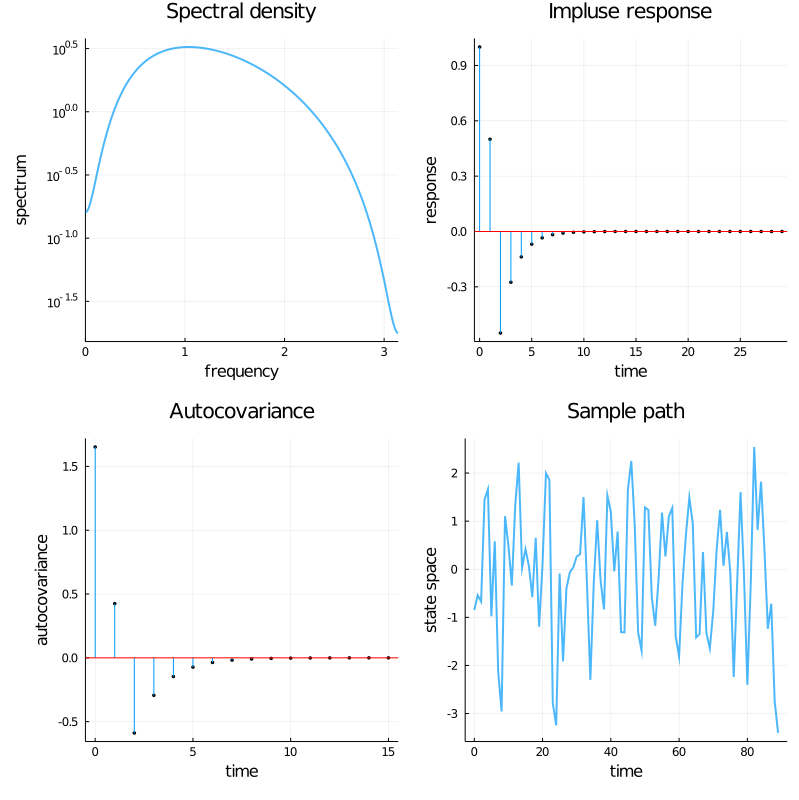

In [8]:
Random.seed!(42) # For reproducible results.
ϕ = 0.5;
θ = [0, -0.8];
arma = ARMA(ϕ, θ, 1.0)
quad_plot(arma)

### Explanation

The call

```julia
arma = ARMA(ϕ, θ, σ)
```


creates an instance `arma` that represents the ARMA($ p, q $) model

$$
X_t = \phi_1 X_{t-1} + ... + \phi_p X_{t-p} +
    \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}
$$

If `ϕ` and `θ` are arrays or sequences, then the interpretation will
be

- `ϕ` holds the vector of parameters $ (\phi_1, \phi_2,..., \phi_p) $  
- `θ` holds the vector of parameters $ (\theta_1, \theta_2,..., \theta_q) $  


The parameter `σ` is always a scalar, the standard deviation of the white noise.

We also permit `ϕ` and `θ` to be scalars, in which case the model will be interpreted as

$$
X_t = \phi X_{t-1} + \epsilon_t + \theta \epsilon_{t-1}
$$

The two numerical packages most useful for working with ARMA models are `DSP.jl` and the `fft` routine in Julia.

### Computing the Autocovariance Function

As discussed above, for ARMA processes the spectral density has a [simple representation](#arma-spec-den) that is relatively easy to calculate.

Given this fact, the easiest way to obtain the autocovariance function is to recover it from the spectral
density via the inverse Fourier transform.

Here we use Julia’s Fourier transform routine fft, which wraps a standard C-based package called FFTW.

A look at [the fft documentation](https://docs.julialang.org/en/stable/stdlib/math/#Base.DFT.fft) shows that the inverse transform ifft takes a given sequence $ A_0, A_1, \ldots, A_{n-1} $ and
returns the sequence $ a_0, a_1, \ldots, a_{n-1} $ defined by

$$
a_k = \frac{1}{n} \sum_{t=0}^{n-1} A_t e^{ik 2\pi t / n}
$$

Thus, if we set $ A_t = f(\omega_t) $, where $ f $ is the spectral density and
$ \omega_t := 2 \pi t / n $, then

$$
a_k
= \frac{1}{n} \sum_{t=0}^{n-1} f(\omega_t) e^{i \omega_t k}
= \frac{1}{2\pi} \frac{2 \pi}{n} \sum_{t=0}^{n-1} f(\omega_t) e^{i \omega_t k},
\qquad
\omega_t := 2 \pi t / n
$$

For $ n $ sufficiently large, we then have

$$
a_k
\approx \frac{1}{2\pi} \int_0^{2 \pi} f(\omega) e^{i \omega k} d \omega
= \frac{1}{2\pi} \int_{-\pi}^{\pi} f(\omega) e^{i \omega k} d \omega
$$

(You can check the last equality)

In view of [(14)](#equation-ift) we have now shown that, for $ n $ sufficiently large, $ a_k \approx \gamma(k) $ — which is exactly what we want to compute.